In [1]:
import pandas as pd
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
import json
%matplotlib inline

def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

wiki = pd.read_csv('people_wiki.csv')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = json.loads(open('people_wiki_map_index_to_word.json').read())

In [2]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


### Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let x and y be normalized vectors, i.e. unit vectors, so that ∥x∥=∥y∥=1. Write the squared Euclidean distance as the dot product of (x−y) to itself:

$∥x−y∥2=(x−y)T(x−y)=∥x∥2−2(xTy)+∥y∥2=2−2(xTy)=21−xTy∥x∥∥y∥$

This tells us that two unit vectors that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the normalize() function from scikit-learn to normalize all vectors to unit length.

In [3]:
tf_idf = normalize(tf_idf)

### Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

Note: We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [4]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:

  *  Assign each data point to the closest centroid.
  *  Revise centroids as the mean of the assigned data points.

In pseudocode, we iteratively do the following:

```pseudo
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

Assigning clusters. How do we implement Step 1 of the main k-means loop above? First import pairwise_distances function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See this documentation for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.


In [5]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)


[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


In [6]:
first_3_centroids = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, first_3_centroids, metric='euclidean')
dist = distances[430, 1]
print(dist)

1.40713106585


More formally, dist[i,j] is assigned the distance between the ith row of X (i.e., X[i,:]) and the jth row of Y (i.e., Y[j,:]).

Checkpoint: For a moment, suppose that we initialize three centroids with the first 3 rows of tf_idf. Write code to compute distances from each of the centroids to all data points in tf_idf. Then find the distance between row 430 of tf_idf and the second centroid and save it to dist. Run the following cell to check your answer.

In [7]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


Checkpoint: Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an argmin function. See this documentation for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as distances. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as closest_cluster. Run the following cell to check your answer.

Hint: the resulting array should be as long as the number of data points.

In [8]:
distances = distances.copy()
closest_cluster = np.argmin(distances, axis=1)

'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


Checkpoint: Let's put these steps together. First, initialize three centroids with the first 3 rows of tf_idf. Then, compute distances from each of the centroids to all data points in tf_idf. Finally, use these distance calculations to compute cluster assignments and assign them to cluster_assignment. Run the following cell to check your code.

In [10]:
first_3_centroids = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, first_3_centroids, metric='euclidean')
cluster_assignment = np.argmin(distances, axis=1)

if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [11]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

which is simply generalization of what we did above.

Checkpoint. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of tf_idf as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of tf_idf. The resulting cluster labels should be [0, 1, 1, 0, 0, 2, 0, 2, 2, 1].



In [12]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments.

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing "data[cluster_assignment==0,:]".

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.



In [13]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [14]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)   # prints [0 1 0]

[0 1 0]


The expression "cluster_assignment==1" gives a list of Booleans that says whether each data point is assigned to cluster 1 or not. For cluster 0, the expression is "cluster_assignment==0". In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a True entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [15]:
print(data[cluster_assignment==1])

[[ 0.  0.  0.]]


The output makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [16]:
print(data[cluster_assignment==0])

[[ 1.  2.  0.]
 [ 2.  2.  0.]]


Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use np.mean(). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the axis argument. See the linked documentation for details.

Use this function to average the data points in cluster 0:

In [17]:
print(data[cluster_assignment==0].mean(axis=0))

[ 1.5  2.   0. ]


We are now ready to complete this function:

In [18]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis = 0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

Checkpoint. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of tf_idf as the data points and the cluster labels [0, 1, 1, 0, 0, 2, 0, 2, 2, 1], we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [19]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as

$J(Z,μ)=∑j=1k∑i:zi=j∥xi−μj∥2$

The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [21]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

 *   Repeatedly performs Steps 1 and 2
 *   Tracks convergence metrics
 *   Stops if either no assignment changed or we reach a certain number of iterations.

In [22]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids

        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.

        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

### Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [23]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step. Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

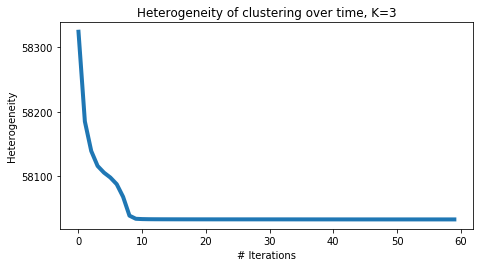

In [24]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

# Question 1
(True/False) The clustering objective (heterogeneity) is non-increasing for this example.

* True

# Question 2
Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running K-means, that would indicate: (choose one)



* There is a bug in the K-means code

# Question 3
Refer to the output of K-means for K=3 and seed=0. Which of the three clusters contains the greatest number of data points in the end?

In [28]:
np.bincount(cluster_assignment)

array([19595, 10427, 29049])

### Beware of local minima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

Note: Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [39]:
k = 10
heterogeneity = {}
cluster_assignment_dict = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    cluster_assignment_dict[seed] = np.bincount(cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
seed=020000, heterogeneity=57533.20100
seed=040000, heterogeneity=57512.69257
seed=060000, heterogeneity=57466.97925
seed=080000, heterogeneity=57494.92990
seed=100000, heterogeneity=57484.42210
seed=120000, heterogeneity=57554.62410
342.25967741012573


# Question 4
Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Compute the size (# of member data points) of clusters for each of the multiple runs of K-means.

Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. What is the minimum value this quantity takes?


In [49]:
for k, v in cluster_assignment_dict.items():
    print(k, np.max(v))

0 18047
20000 15779
40000 18132
60000 17900
80000 17582
100000 16969
120000 16481


One effective way to counter this tendency is to use k-means++ to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [36]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [37]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57441.33298
seed=020000, heterogeneity=57457.50383
seed=040000, heterogeneity=57469.82237
seed=060000, heterogeneity=57503.05355
seed=080000, heterogeneity=57464.05684
seed=100000, heterogeneity=57487.57010
seed=120000, heterogeneity=57534.79120
432.0667099952698


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization. The following code produces a box plot for each of these methods, indicating the spread of values produced by each method.

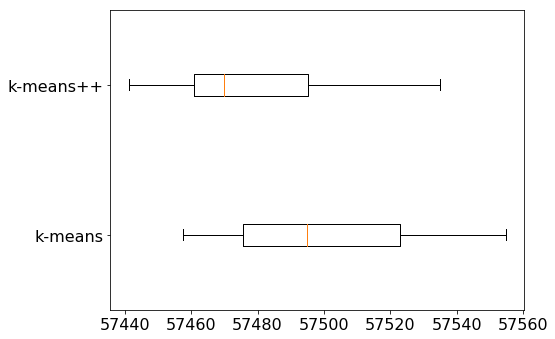

In [45]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:

 *   On average, k-means++ produces a better clustering than Random initialization.
 *   Variation in clustering quality is smaller for k-means++.

In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity. Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values. 

In [73]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization

        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means

        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400,
                                               record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end

        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

### How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition. For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.) Let's see explore this general trend for ourselves by performing the following analysis.

Use the kmeans_multiple_runs function to run k-means with five different values of K. For each K, use k-means++ and multiple runs to pick the best solution. In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

IMPORTANT: The code block below will take about one hour to finish. We highly suggest that you use the arrays that we have computed for you. Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see scikit-learn's KMeans.

seed=000000, heterogeneity=58224.59913
seed=020000, heterogeneity=58179.57453
seed=040000, heterogeneity=58179.57453
seed=060000, heterogeneity=58179.57453
seed=080000, heterogeneity=58224.59952
seed=100000, heterogeneity=58179.57453
seed=120000, heterogeneity=58179.57453
seed=000000, heterogeneity=57441.33298
seed=020000, heterogeneity=57457.50383
seed=040000, heterogeneity=57469.82237
seed=060000, heterogeneity=57503.05355
seed=080000, heterogeneity=57464.05684
seed=100000, heterogeneity=57487.57010
seed=120000, heterogeneity=57534.79120
seed=000000, heterogeneity=56828.55406
seed=020000, heterogeneity=56943.91794
seed=040000, heterogeneity=56816.94257
seed=060000, heterogeneity=56920.95767
seed=080000, heterogeneity=56884.99112
seed=100000, heterogeneity=56875.89487
seed=120000, heterogeneity=56911.66467
seed=000000, heterogeneity=56339.57044
seed=020000, heterogeneity=56351.77299
seed=040000, heterogeneity=56299.53728
seed=060000, heterogeneity=56324.49665
seed=080000, heterogeneit

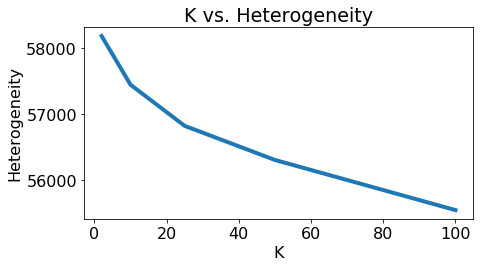

In [74]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

start = time.time()
centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                               num_runs=len(seed_list),
                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

end = time.time()
print(end-start)

To use the pre-computed NumPy arrays, first download kmeans-arrays.npz as mentioned in the reading for this assignment and load them with the following code. Make sure the downloaded file is in the same directory as this notebook.

2
10
25
50
100


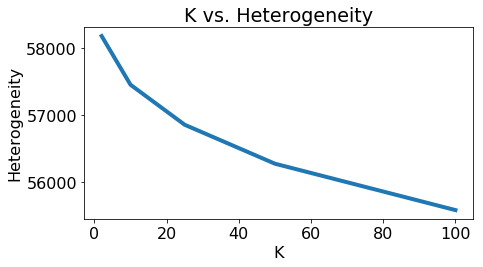

In [51]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? Not at all! As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

### Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense. We can use such visualizations to help us assess whether we have set K too large or too small for a given application. Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?

 *   Documents in the same cluster should be similar.
 *   Documents from different clusters should be less similar. 

So a bad clustering exhibits either of two symptoms:

  *  Documents in a cluster have mixed content.
  *  Documents with similar content are divided up and put into different clusters. 

To help visualize the clustering, we do the following:

 *   Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
 *   Print titles and first sentences of those nearest neighbors.
 *   Print top 5 words that have highest tf-idf weights in each centroid. 

In [90]:
map_index_to_word

{'biennials': 522004,
 'lb915': 116290,
 'shatzky': 127647,
 'woode': 174106,
 'damfunk': 133206,
 'nualart': 153444,
 'hatefillot': 164111,
 'missionborn': 261765,
 'yeardescribed': 161075,
 'theoryhe': 521685,
 'vinalop': 222759,
 'soestdijk': 166345,
 'boncea': 150371,
 'spiders': 519990,
 'bienniale': 429277,
 'woody': 541515,
 'trawling': 189895,
 'pampoulovawagner': 201040,
 'bentara': 202586,
 'laserbased': 25758,
 'caner': 346073,
 'canes': 478262,
 'canet': 436468,
 'iaspark': 395341,
 'categoriesborn': 12586,
 '5982': 277649,
 'caney': 459867,
 'phosphorushe': 379479,
 'yusaf': 270311,
 'hhsoffice': 141697,
 '5985': 32985,
 'fsos': 109474,
 'caned': 324502,
 'gaa': 534680,
 'iguau': 456103,
 'storiesin': 513151,
 'braziljorge': 107111,
 'iguaz': 127410,
 'kealhofer': 342134,
 'canek': 159182,
 '2116': 429919,
 'canem': 83461,
 'victorialooking': 58169,
 'martre': 111954,
 'lippert': 491344,
 'pagesolove': 33220,
 'sowell': 489254,
 'weiskopfs': 344360,
 'hedquist': 165506,
 '

In [109]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
             print('{0:s}:{1:.3f}'.format(list(map_index_to_word.keys())[list(map_index_to_word.values()).index(idx[i])], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                #print(text)
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
                    
        
        print('==========================================================')

Let us first look at the 2 cluster case (K=2). 

In [110]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0    
she:0.025
her:0.017
music:0.012
he:0.011
university:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                         

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:

 *   Cluster 0: artists, songwriters, professors, politicians, writers, etc.
 *   Cluster 1: baseball players, hockey players, soccer (association football) players, etc.

Top words of cluster 1 are all related to sports, whereas top words of cluster 0 show no clear pattern.

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-athletes into more categories. So let us use more clusters. How about K=10?



In [111]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0    
art:0.013
he:0.012
book:0.010
his:0.009
that:0.009


* Wilson McLean                                      0.97609
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Tang Xiyang                                        0.97913
  tang xiyang born january 30 1930 in miluo hunan province is a chinese environmentalist he 
  was awarded the 2007 ramon magsaysay award for peace and

* David Salle                                        0.98020
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Alberto Blanco (poet)                              0.98051
  alberto blanco is considered one of mexicos most important poets born in mexico city on fe
  bruary 18 1951 he spent his childhood and adolescence in

* David Elliott (curator)                            0.98159


music:0.056
album:0.040
band:0.035
orchestra:0.023
released:0.022


* Brenton Broadstock                                 0.95729
  brenton broadstock ao born 1952 is an australian composerbroadstock was born in melbourne 
  he studied history politics and music at monash university and later composition

* Prince (musician)                                  0.96053
  prince rogers nelson born june 7 1958 known by his mononym prince is an american singerson
  gwriter multiinstrumentalist and actor he has produced ten platinum albums

* Will.i.am                                          0.96066
  william adams born march 15 1975 known by his stage name william pronounced will i am is a
  n american rapper songwriter entrepreneur actor dj record

* Tom Bancroft                                       0.96121
  tom bancroft born 1967 london is a british jazz drummer and composer he began drumming age
  d seven and started off playing jazz with his father

* Julian Knowles                     

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.

  *  Cluster 0: artists, actors, film directors, playwrights
  *  Cluster 1: soccer (association football) players, rugby players
  *  Cluster 2: track and field athletes
  *  Cluster 3: baseball players
  *  Cluster 4: professors, researchers, scholars
  *  Cluster 5: Austrailian rules football players, American football players
  *  Cluster 6: female figures from various fields
  *  Cluster 7: composers, songwriters, singers, music producers
  *  Cluster 8: ice hockey players
  *  Cluster 9: politicians

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of cluster is to count the number of articles in each cluster.

In [112]:
np.bincount(cluster_assignment[10])

array([17791,  3756,  6642,  5165,  3356,  7125,  6467,  1739,  5684,  1346])

# Question 5
Refer to the section "Visualize clusters of documents". Which of the 10 clusters above contains the greatest number of articles?

* Cluster 0: artists, actors, film directors, playwrights

# Question 6
Refer to the section "Visualize clusters of documents". Which of the 10 clusters above contains the least number of articles?

* Cluster 8: ice hockey players

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.



In [113]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
album:0.055
band:0.046
music:0.042
released:0.029
jazz:0.024

Cluster 1    
poetry:0.202
poems:0.078
poet:0.066
literary:0.041
poets:0.040

Cluster 2    
rugby:0.198
cup:0.049
against:0.046
played:0.044
wales:0.039

Cluster 3    
league:0.096
baseball:0.091
season:0.047
games:0.047
major:0.044

Cluster 4    
president:0.024
board:0.024
chairman:0.022
served:0.020
business:0.020

Cluster 5    
football:0.061
league:0.056
club:0.049
season:0.048
played:0.038

Cluster 6    
radio:0.081
news:0.059
show:0.049
bbc:0.034
television:0.030

Cluster 7    
theatre:0.066
series:0.035
television:0.034
actor:0.034
comedy:0.032

Cluster 8    
research:0.051
university:0.039
professor:0.039
science:0.030
institute:0.022

Cluster 9    
law:0.141
court:0.088
judge:0.066
district:0.045
justice:0.042

Cluster 10    
marathon:0.132
metres:0.124
championships:0.116
she:0.079
athletics:0.071

Cluster 11    
he:0.011
that:0.010
his:0.009
were:0.007
had:0.007

Cluster 12    
racing:0.036
champion

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.

 *   Cluster 0: lawyers, judges, legal scholars
 *   Cluster 1: professors, researchers, scholars (natural and health sciences)
 *   Cluster 2: ice hockey players
 *   Cluster 3: politicans
 *   Cluster 4: government officials
 *   Cluster 5: politicans
 *   Cluster 6: professors, researchers, scholars (social sciences and humanities)
 *   Cluster 7: Canadian politicians
 *   Cluster 8: car racers
 *   Cluster 9: economists
 *   Cluster 10: track and field athletes
 *   Cluster 11: females from various fields
 *  Cluster 12: (mixed; no clear theme)
 *   Cluster 13: baseball players
 *   Cluster 14: painters, sculptors, artists
 *   Cluster 15: Austrailian rules football players, American football players
 *   Cluster 16: musicians, composers
 *   Cluster 17: soccer (association football) players, rugby players
 *   Cluster 18: poets
 *   Cluster 19: film directors, playwrights
 *   Cluster 20: songwriters, singers, music producers
 *   Cluster 21: generals of U.S. Air Force
 *   Cluster 22: music directors, conductors
 *   Cluster 23: basketball players
 *   Cluster 24: golf players

Indeed, increasing K achieved the desired effect of breaking up large clusters. Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [114]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0    
brazilian:0.135
brazil:0.083
de:0.057
rio:0.051
paulo:0.051

Cluster 1    
film:0.183
festival:0.054
films:0.052
documentary:0.037
directed:0.036

Cluster 2    
comics:0.197
comic:0.123
strip:0.038
graphic:0.037
book:0.034

Cluster 3    
mayor:0.142
city:0.047
council:0.037
elected:0.032
election:0.028

Cluster 4    
tour:0.258
pga:0.215
golf:0.140
open:0.073
golfer:0.062

Cluster 5    
band:0.111
album:0.048
bands:0.032
rock:0.032
guitar:0.031

Cluster 6    
football:0.120
afl:0.113
australian:0.083
season:0.058
club:0.058

Cluster 7    
cricket:0.194
firstclass:0.114
cricketer:0.074
batsman:0.068
wickets:0.061

Cluster 8    
physics:0.181
quantum:0.064
theoretical:0.049
theory:0.042
research:0.041

Cluster 9    
editor:0.052
journalism:0.042
journalist:0.035
news:0.031
times:0.030

Cluster 10    
history:0.054
university:0.043
studies:0.039
professor:0.037
research:0.025

Cluster 11    
rugby:0.219
cup:0.058
against:0.051
union:0.046
played:0.043

Cluster 12    
electio

single:0.040
song:0.039
music:0.039

Cluster 58    
music:0.056
jazz:0.051
album:0.024
records:0.021
band:0.021

Cluster 59    
iraqi:0.180
iraq:0.148
baghdad:0.060
saddam:0.047
hussein:0.038

Cluster 60    
olympics:0.060
championships:0.057
olympic:0.055
world:0.040
medal:0.038

Cluster 61    
racing:0.126
formula:0.078
race:0.066
car:0.061
driver:0.055

Cluster 62    
air:0.382
force:0.247
command:0.110
commander:0.099
base:0.083

Cluster 63    
orchestra:0.204
symphony:0.148
conductor:0.111
music:0.076
philharmonic:0.076

Cluster 64    
wrestling:0.300
wwe:0.167
wrestler:0.091
tag:0.080
championship:0.080

Cluster 65    
freestyle:0.154
swimming:0.123
m:0.118
swimmer:0.090
heat:0.075

Cluster 66    
hurling:0.170
allireland:0.150
munster:0.095
intercounty:0.090
cork:0.083

Cluster 67    
gay:0.195
lesbian:0.067
lgbt:0.053
queer:0.026
bisexual:0.024

Cluster 68    
lds:0.194
church:0.184
churchs:0.099
latterday:0.072
seventy:0.072

Cluster 69    
opera:0.265
she:0.065
la:0.040
sang:

The class of soccer (association football) players has been broken into two clusters (44 and 45). Same goes for Austrialian rules football players (clusters 26 and 48). The class of baseball players have been also broken into two clusters (16 and 91).

A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much granularity we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

There is no golden rule for choosing K. It all depends on the particular application and domain we are in.

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows. Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K. This naturally trades off between trying to minimize heterogeneity, but reduce model complexity. In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

# Question 7

Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?

In [115]:
cluster_assignment_bincount = np.bincount(cluster_assignment[100])
len(cluster_assignment_bincount[cluster_assignment_bincount <= 236])

35